In [3]:
import numpy as np
import pandas as pd

# Load Dataset
dataset = pd.read_csv("retweet_data.csv")[:610]

In [7]:
X = dataset['retweet_text'].tolist()

In [9]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cheng\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

In [10]:
import re
import nltk
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for num in range(len(X)):  
    # 去URL
    document = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', X[num])
    
    # 去標點
    document = re.sub(r'\W', ' ', document)

    # 去單一字母s
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # 轉小寫
    document = document.lower()

    # Lemmatization
    document = document.split()

    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)

    documents.append([document])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

X_tfidf = vectorizer.fit_transform(X)

In [22]:
# from sklearn.decomposition import PCA 
# pca=PCA(n_components=2)
# newData=pca.fit_transform(X_tfidf)

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
X_tfidf_reduce = svd.fit_transform(X_tfidf)

In [26]:
X_tfidf_reduce.T[0]

array([ 7.05526878e-02,  6.43779114e-02,  3.06264607e-02,  2.25267939e-02,
        1.13388392e-01,  5.99663555e-02,  5.87304090e-02,  3.73960419e-02,
        6.78897197e-03,  8.86199401e-03,  1.96004380e-02,  2.35038932e-02,
        3.33786919e-02,  3.86903329e-02,  2.85174447e-02,  2.46145979e-02,
        3.72127342e-02,  3.70188307e-02,  3.15876058e-02,  3.00671175e-02,
        1.06136779e-02,  2.04807054e-02,  1.32309051e-01,  1.22256467e-02,
        1.98418235e-02,  3.92295953e-02,  4.33652520e-03,  5.08781735e-02,
        1.81127902e-02,  4.91114600e-02,  5.94486592e-02,  4.56365416e-02,
        1.64087056e-02,  2.62319910e-02,  3.40742967e-02,  6.07077540e-02,
        5.20380818e-02,  2.63559953e-03,  6.08498938e-03,  4.46874128e-02,
        3.94385757e-02,  1.68572593e-02,  2.69182100e-02,  6.46550537e-03,
        3.43097529e-02,  2.15896575e-02,  4.48406477e-02,  1.01880858e-02,
        1.14019162e-01,  1.00022866e-02,  7.74438748e-02,  4.77428232e-02,
        4.32573578e-03,  

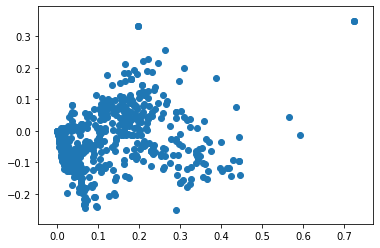

In [28]:
import matplotlib.pyplot as plt
plt.scatter(X_tfidf_reduce.T[0], X_tfidf_reduce.T[1], marker='o')
plt.show()

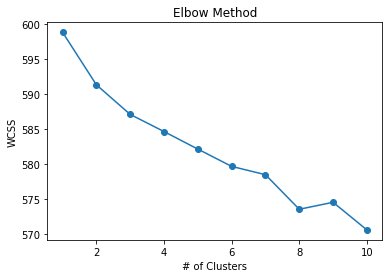

In [30]:
#K-Means Clustering
from sklearn.cluster import KMeans
import time

### Find Best K
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=int(time.time()))
    kmeans.fit(X_tfidf)
    wcss.append(kmeans.inertia_)
##
### Draw WCSS for each K
import matplotlib.pyplot as plt
##
plt.plot(range(1, 11), wcss,'o-')
plt.title("Elbow Method")
plt.xlabel("# of Clusters")
plt.ylabel("WCSS")
#plt.savefig("doc2vec_text8_elbow.png")
plt.show()

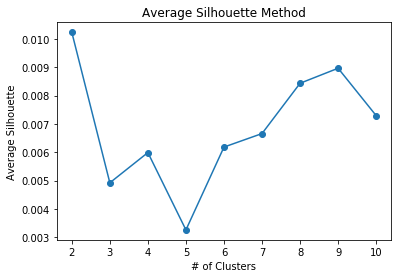

In [34]:
from sklearn.metrics import silhouette_score

silhouette = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=int(time.time()))
    kmeans.fit(X_tfidf)
    silhouette.append(silhouette_score(X_tfidf, kmeans.labels_))

plt.plot(range(2, 11), silhouette,'o-')
plt.title("Average Silhouette Method")
plt.xlabel("# of Clusters")
plt.ylabel("Average Silhouette")
plt.show()

In [36]:
#Prediction
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=int(time.time()))
Y_pred = kmeans.fit_predict(X_tfidf)

In [45]:
dataset['pred'] = Y_pred
dataset.to_csv("retweet_prediction_tf-idf.csv")

In [42]:
df = pd.DataFrame(X_tfidf_reduce, columns=['PC1','PC2'])
df['pred'] = Y_pred
df

,PC1,PC2,pred
0,0.070553,-0.119187,0
1,0.064378,-0.127057,0
2,0.030626,-0.068035,0
3,0.022527,-0.044540,0
4,0.113388,0.053790,0
...,...,...,...
605,0.138687,-0.197822,0
606,0.140327,-0.203273,0
607,0.164325,0.075259,1
608,0.164325,0.075259,1


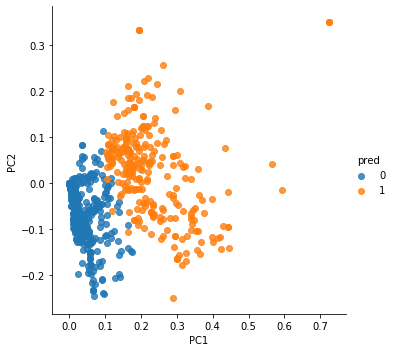

In [43]:
import seaborn as sns
facet = sns.lmplot(data=df, x='PC1', y='PC2', hue='pred', 
                   fit_reg=False, legend=True, legend_out=True)